In this project we implement KNN, decision tree, random forest and apply bagging/boosting. Finally we have histogram and kernal density estimation. The dataset used here is the toy dataset from sklearn diabetes.

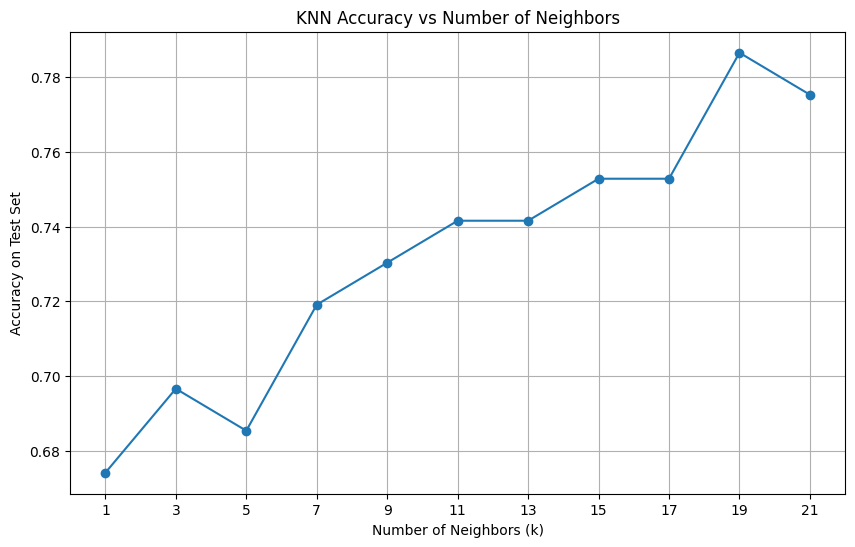

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Load the diabetes dataset
diabetes_sklearn = load_diabetes()
## convert the diabete dataset to pandas form
data = pd.DataFrame(data= np.c_[diabetes_sklearn['data'], diabetes_sklearn['target']],
                     columns= diabetes_sklearn['feature_names'] + ['target'])
# Separate the features, target values, and feature names
X = data.drop('target', axis=1)
y = data['target'].values

# Create an imbalanced target variable
y= np.where(y > np.percentile(y, 50), 1, 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

class KNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        # Calculate distances between x and all examples in the training set
        distances = [np.sqrt(np.sum((x_train - x) ** 2)) for x_train in self.X_train]

        # Sort by distance and return indices of the first k neighbors
        k_indices = np.argsort(distances)[:self.k]

        # Extract the labels of the k nearest neighbor training samples
        k_nearest_labels = [self.y_train[i] for i in k_indices]

        # Return the most common class label
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]
k_values = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
accuracies = []

# Test KNN for each value of k
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o')
plt.title('KNN Accuracy vs Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy on Test Set')
plt.xticks(k_values)
plt.grid(True)
plt.show()

Decision Tree Accuracy: 0.6741573033707865


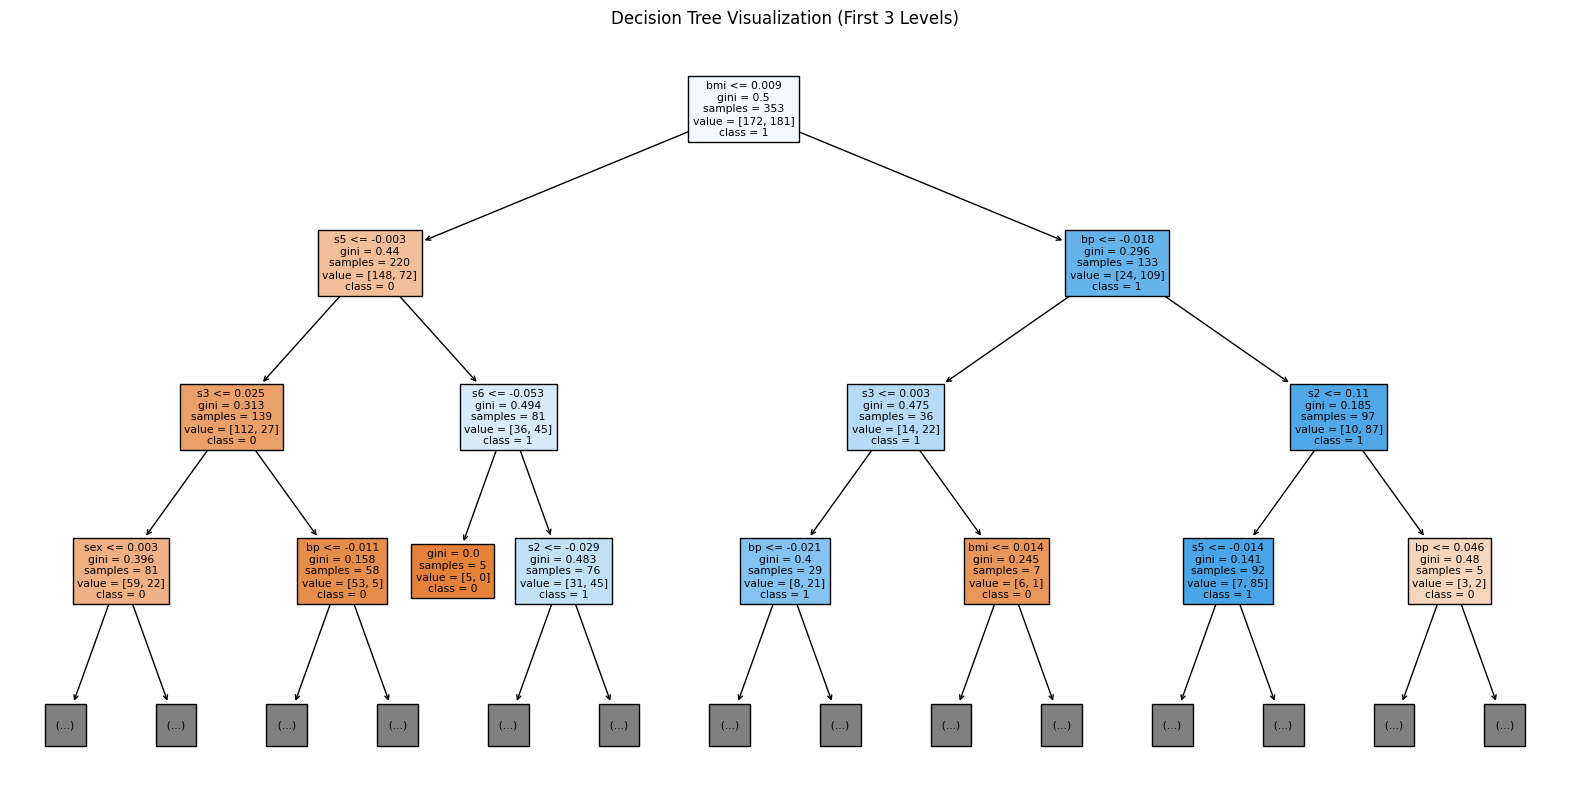

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


# Train a Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

# Evaluate performance on the test set
dt_accuracy = accuracy_score(y_test, dt_classifier.predict(X_test))
print("Decision Tree Accuracy:", dt_accuracy)

# Visualize the Decision Tree
plt.figure(figsize=(20,10))
plot_tree(dt_classifier, filled=True, feature_names=X.columns, class_names=['0', '1'], max_depth=3)
plt.title("Decision Tree Visualization (First 3 Levels)")
plt.show()

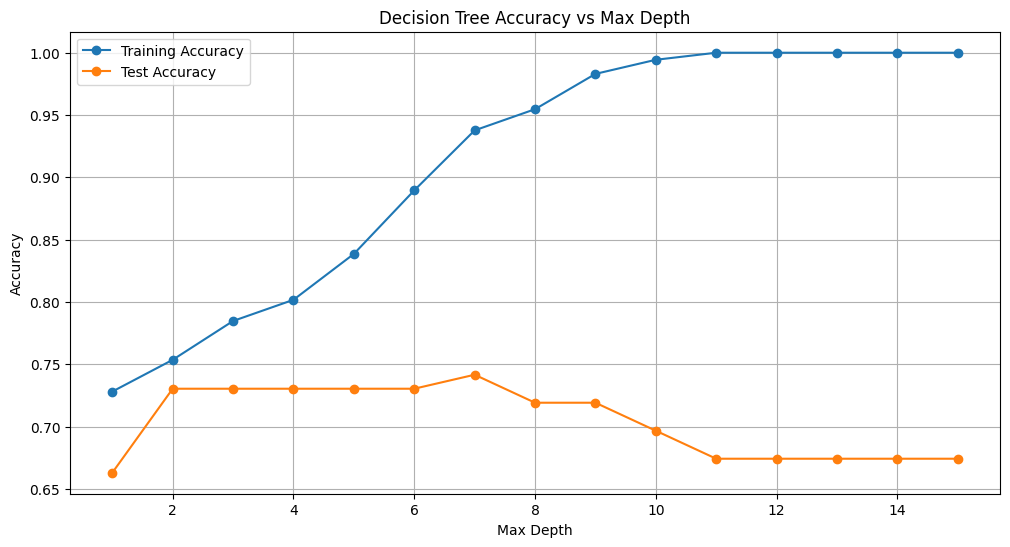

In [14]:
#Train Decision Trees with varying max_depth and plot accuracies
train_accuracies = []
test_accuracies = []

for depth in range(1, 16):
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)

    # Accuracy on training set
    train_accuracy = accuracy_score(y_train, dt.predict(X_train))
    train_accuracies.append(train_accuracy)

    # Accuracy on test set
    test_accuracy = accuracy_score(y_test, dt.predict(X_test))
    test_accuracies.append(test_accuracy)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(range(1, 16), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1, 16), test_accuracies, label='Test Accuracy', marker='o')
plt.title('Decision Tree Accuracy vs Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
import numpy as np
from sklearn.base import clone
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

class CustomBaggingClassifier:
    def __init__(self, base_estimator=DecisionTreeClassifier(), n_estimators=10, bootstrap_size=None):
        """
        Initialize the CustomBaggingClassifier.

        Parameters:
        base_estimator: The base model to use (default is DecisionTreeClassifier).
        n_estimators: The number of base models in the ensemble.
        bootstrap_size: The number of samples to draw from X to train each base model.
        """
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.bootstrap_size = bootstrap_size
        self.models = []

    def _bootstrap(self, X, y):
        """
        Create a bootstrap sample of the dataset.

        Fill in this method to generate a bootstrap sample.
        """
        # Implement bootstrapping
        # If bootstrap_size is not specified, use the size of the dataset
        if self.bootstrap_size is None:
            self.bootstrap_size = len(X)

        # Randomly sample indices with replacement
        indices = np.random.choice(range(len(X)), size=self.bootstrap_size, replace=True)

        # Return the bootstrap sample
        return X.iloc[indices], y[indices]

    def fit(self, X, y):
        """
        Fit the bagging ensemble classifier.

        Fill in this method to train n_estimators of the base_estimator on
        different bootstrap samples of the dataset.
        """
        # Implement the fitting process
        for _ in range(self.n_estimators):
            # Create a bootstrap sample
            X_sample, y_sample = self._bootstrap(X, y)

            # Clone the base estimator and fit it to the bootstrap sample
            model = clone(self.base_estimator)
            model.fit(X_sample, y_sample)

            # Add the trained model to the ensemble
            self.models.append(model)

    def predict(self, X):
        """
        Make predictions with the bagging ensemble classifier.

        Fill in this method to aggregate predictions from all base models.
        """
        # Implement the prediction process
        # Get predictions from all models
        predictions = np.array([model.predict(X) for model in self.models])

        # Aggregate predictions by taking the mode (majority vote)
        final_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)

        return final_predictions
        pass

    def score(self, X, y):
        """
        Return the accuracy of the bagging ensemble classifier on the provided data and labels.
        """
        predictions = self.predict(X)
        return accuracy_score(y, predictions)
    def get_params(self, deep=True):
        return {"base_estimator": self.base_estimator, "n_estimators": self.n_estimators, "bootstrap_size": self.bootstrap_size}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self



In [16]:
## Add code to evaluate the bagging classifier on the test set
# Initialize the CustomBaggingClassifier with default parameters
bagging_classifier = CustomBaggingClassifier()

# Fit the bagging classifier on the training data
bagging_classifier.fit(X_train, y_train)

# Evaluate the bagging classifier on the test set
bagging_test_accuracy = bagging_classifier.score(X_test, y_test)

# Initialize a single decision tree classifier
single_tree_classifier = DecisionTreeClassifier(random_state=42)

# Fit the single decision tree classifier on the training data
single_tree_classifier.fit(X_train, y_train)

# Evaluate the single decision tree classifier on the test set
single_tree_test_accuracy = single_tree_classifier.score(X_test, y_test)

(bagging_test_accuracy, single_tree_test_accuracy)

(0.6853932584269663, 0.6741573033707865)

In [17]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

# Define the base estimator for AdaBoost as a decision tree with max_depth=1
ada_base_estimator = DecisionTreeClassifier(max_depth=1)

# Initialize the AdaBoostClassifier with the base estimator
ada_boost_classifier = AdaBoostClassifier(estimator=ada_base_estimator)

# Fit the AdaBoost classifier on the training data
ada_boost_classifier.fit(X_train, y_train)

# Evaluate the AdaBoost classifier on the test set
ada_boost_test_accuracy = ada_boost_classifier.score(X_test, y_test)

# Initialize the GradientBoostingClassifier with max_depth=1 for its internal estimators
gradient_boosting_classifier = GradientBoostingClassifier(max_depth=1)

# Fit the Gradient Boosting classifier on the training data
gradient_boosting_classifier.fit(X_train, y_train)

# Evaluate the Gradient Boosting classifier on the test set
gradient_boosting_test_accuracy = gradient_boosting_classifier.score(X_test, y_test)

(ada_boost_test_accuracy, gradient_boosting_test_accuracy)

(0.6741573033707865, 0.7303370786516854)

In [18]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {'n_estimators': range(10, 101, 1)}

# Initialize the GridSearchCV object for AdaBoost
grid_search = GridSearchCV(AdaBoostClassifier(estimator=ada_base_estimator),
                           param_grid, cv=5, scoring='accuracy')

# Fit grid_search on the training data
grid_search.fit(X_train, y_train)

# Best number of estimators
best_n_estimators = grid_search.best_params_['n_estimators']
print("Best number of estimators for AdaBoost:", best_n_estimators)

# Evaluate on the test set
best_ada_boost = grid_search.best_estimator_
ada_boost_grid_accuracy = best_ada_boost.score(X_test, y_test)
print("AdaBoost accuracy after grid search:", ada_boost_grid_accuracy)



grad_param_grid = {'n_estimators': range(10, 101, 1)}
# Initialize the GridSearchCV object for Gradient Boosting
gradient_boosting_grid_search = GridSearchCV(GradientBoostingClassifier(max_depth=1),
                                             grad_param_grid, cv=5, scoring='accuracy')

# Fit grid_search on the training data
gradient_boosting_grid_search.fit(X_train, y_train)

# Best number of estimators
best_n_estimators_gradient_boosting = gradient_boosting_grid_search.best_params_['n_estimators']
print("Best number of estimators for Gradient Boosting:", best_n_estimators_gradient_boosting)

# Evaluate on the test set
best_gradient_boosting = gradient_boosting_grid_search.best_estimator_
gradient_boosting_grid_accuracy = best_gradient_boosting.score(X_test, y_test)
print("Gradient Boosting accuracy after grid search:", gradient_boosting_grid_accuracy)

# Define the parameter grid
bagging_param_grid = {'n_estimators': range(10, 101, 1)}

# Initialize the GridSearchCV object for Bagging
bagging_grid_search = GridSearchCV(CustomBaggingClassifier(base_estimator=DecisionTreeClassifier()),
                                   bagging_param_grid, cv=5, scoring='accuracy')

# Fit grid_search on the training data
bagging_grid_search.fit(X_train, y_train)

# Best number of estimators
best_n_estimators_bagging = bagging_grid_search.best_params_['n_estimators']
print("Best number of estimators for Bagging:", best_n_estimators_bagging)

# Evaluate on the test set
best_bagging = bagging_grid_search.best_estimator_
bagging_grid_accuracy = best_bagging.score(X_test, y_test)
print("Bagging accuracy after grid search:", bagging_grid_accuracy)




Best number of estimators for AdaBoost: 14
AdaBoost accuracy after grid search: 0.7191011235955056
Best number of estimators for Gradient Boosting: 29
Gradient Boosting accuracy after grid search: 0.7303370786516854
Best number of estimators for Bagging: 46
Bagging accuracy after grid search: 0.6966292134831461


In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Construct and Evaluate Random Forest Classifier

# Define the Random Forest Classifier with chosen hyperparameters
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=42)

# Fit the Random Forest Classifier on the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
rf_predictions = rf_classifier.predict(X_test)

# Evaluate performance by calculating accuracy
rf_accuracy = accuracy_score(y_test, rf_predictions)

print("Random Forest Classifier Accuracy:", rf_accuracy)
# Define the Decision Tree Classifier with chosen hyperparameters
decision_tree_classifier = DecisionTreeClassifier(max_depth=10, random_state=42)

# Fit the Decision Tree Classifier on the training data
decision_tree_classifier.fit(X_train, y_train)

# Make predictions on the test set
decision_tree_predictions = decision_tree_classifier.predict(X_test)

# Evaluate performance by calculating accuracy
decision_tree_accuracy = accuracy_score(y_test, decision_tree_predictions)

print("Decision Tree Classifier Accuracy:", decision_tree_accuracy)

Random Forest Classifier Accuracy: 0.7415730337078652
Decision Tree Classifier Accuracy: 0.6966292134831461


In [20]:
n_estimators_list = [10, 50, 100, 200]

# Initialize lists to store training and test accuracies for each number of estimators
train_accuracies = []
test_accuracies = []

# Iterate over the number of estimators
for n_estimators in n_estimators_list:
    # Create and fit the Random Forest Classifier with the current number of estimators
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf_classifier.fit(X_train, y_train)

    # Make predictions on the training and test sets
    train_predictions = rf_classifier.predict(X_train)
    test_predictions = rf_classifier.predict(X_test)

    # Calculate training and test accuracies
    train_accuracy = accuracy_score(y_train, train_predictions)
    test_accuracy = accuracy_score(y_test, test_predictions)

    # Append accuracies to the lists
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Print the results
for i, n_estimators in enumerate(n_estimators_list):
    print(f"Number of Estimators: {n_estimators}")
    print(f"Training Accuracy: {train_accuracies[i]}")
    print(f"Test Accuracy: {test_accuracies[i]}")
    print()

Number of Estimators: 10
Training Accuracy: 0.9830028328611898
Test Accuracy: 0.7191011235955056

Number of Estimators: 50
Training Accuracy: 1.0
Test Accuracy: 0.7415730337078652

Number of Estimators: 100
Training Accuracy: 1.0
Test Accuracy: 0.7191011235955056

Number of Estimators: 200
Training Accuracy: 1.0
Test Accuracy: 0.7415730337078652



In [21]:
# Grid search

param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [4, 6, 8, 10],
}

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best Random Forest model with the optimal hyperparameters
best_rf_classifier = grid_search.best_estimator_

# Evaluate the best model on the test set
best_rf_accuracy = best_rf_classifier.score(X_test, y_test)
print("Random Forest Accuracy with Optimal Hyperparameters:", best_rf_accuracy)

Best Hyperparameters: {'max_depth': 4, 'n_estimators': 50}
Random Forest Accuracy with Optimal Hyperparameters: 0.7191011235955056


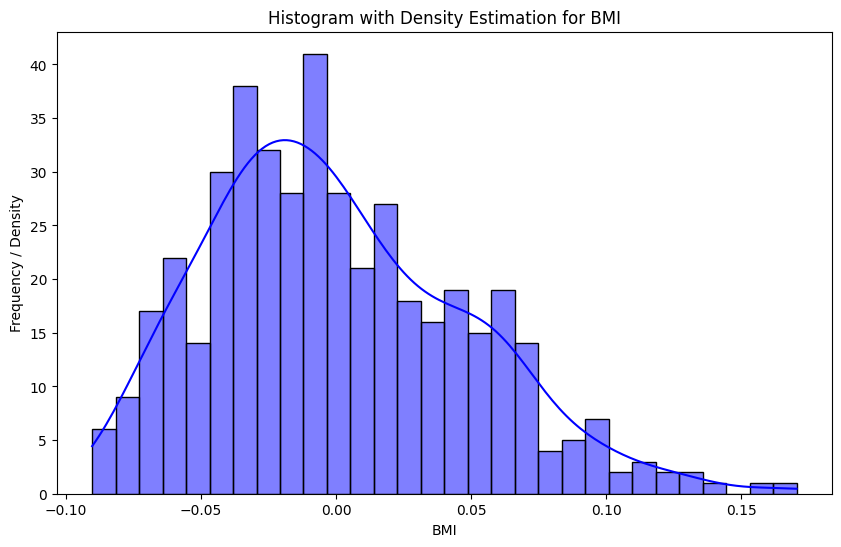

In [7]:

import seaborn as sns


# Extract the BMI feature from the dataset
bmi_feature = X['bmi']

# Create a histogram with 30 equal-width bins and density estimation
plt.figure(figsize=(10, 6))
sns.histplot(bmi_feature, bins=30, kde=True, color='blue')

# Set plot labels and title
plt.xlabel("BMI")
plt.ylabel("Frequency / Density")
plt.title("Histogram with Density Estimation for BMI")

# Show the plot
plt.show()

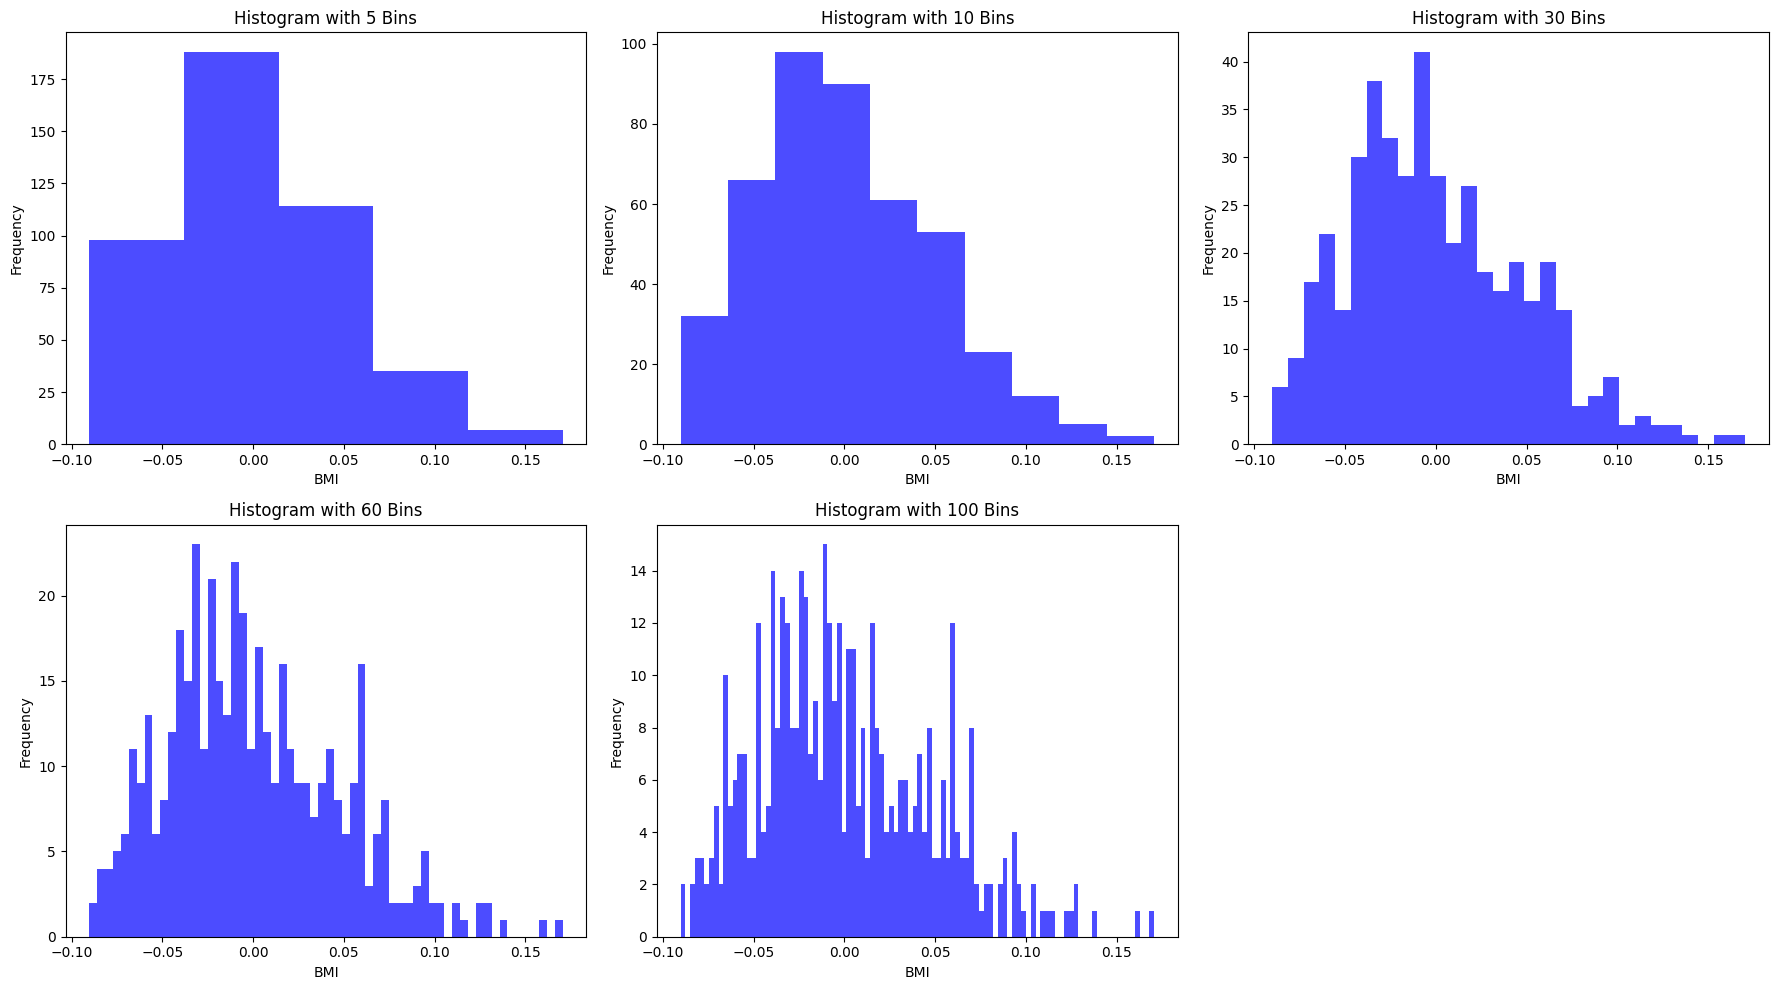

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns


# Extract the BMI feature from the dataset
bmi_feature = X['bmi']

# List of different numbers of bins to try
num_bins_list = [5, 10, 30, 60, 100]

# Create subplots for each histogram
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for i, num_bins in enumerate(num_bins_list):
    row = i // 3
    col = i % 3

    # Plot the histogram with the current number of bins
    axes[row, col].hist(bmi_feature, bins=num_bins, color='blue', alpha=0.7)

    # Set plot labels and title
    axes[row, col].set_xlabel("BMI")
    axes[row, col].set_ylabel("Frequency")
    axes[row, col].set_title(f"Histogram with {num_bins} Bins")

# Adjust layout
plt.tight_layout()

if len(num_bins_list) < 6:
    fig.delaxes(axes[1, 2])

# Show the plots
plt.show()

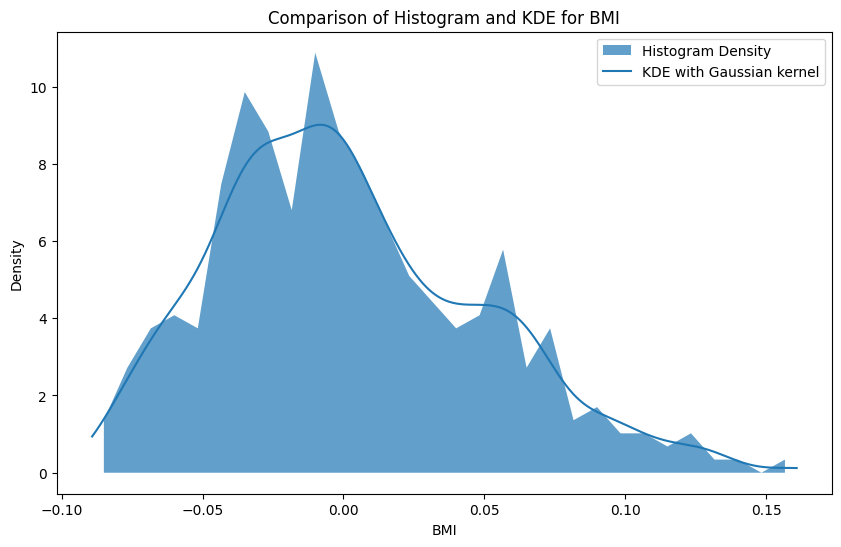

In [24]:

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde

np.random.seed(42)
BMI_data = X_train['bmi']
# KDE with Gaussian kernel
bandwidth = 0.01
BMI_array = BMI_data.to_numpy().reshape(-1, 1)  # Convert to a NumPy array and reshape

# Now use KernelDensity on the NumPy array
kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(BMI_array)


# Histogram Density Estimation
hist_density, bins = np.histogram(BMI_data, bins=30, density=True)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# Evaluating KDE for a range of values
X_plot = np.linspace(np.min(BMI_data), np.max(BMI_data), 1000)[:, np.newaxis]
log_dens = kde.score_samples(X_plot)

# Plotting
plt.figure(figsize=(10, 6))
plt.fill_between(bin_centers, hist_density, alpha=0.7, label='Histogram Density')
plt.plot(X_plot[:, 0], np.exp(log_dens), '-', label='KDE with Gaussian kernel')
plt.title('Comparison of Histogram and KDE for BMI')
plt.xlabel('BMI')
plt.ylabel('Density')
plt.legend()
plt.show()
